In [1329]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, Imputer, StandardScaler
import random
import seaborn as sns
from sklearn_pandas.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from functions import ohe, logireg, gb, xgb, rf, predict_probability_and_class
from sklearn.metrics import (roc_curve, auc, precision_recall_curve, make_scorer, 
recall_score, accuracy_score, precision_score, confusion_matrix)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1330]:
#had to install xgboost
#!pip install xgboost

## Load data

In [1331]:
df_approved = pd.read_csv('data/pf_approved_loan_data_nov.csv', index_col=False)
df_rejected = pd.read_csv('data/pf_rejected_loan_data_nov.csv', index_col=False)

## EDA

In [1332]:
len(df_rejected)

2927

In [1333]:
# Drop Innamed and Loan ID column

df_rejected = df_rejected.drop(['Unnamed: 0', 'loan_id'], axis=1)
df_rejected.head()

,monthly_income,gig_economy_weekly_income,atm_check_deposits_weekly_income,direct_deposit_weekly_income,government_aid_weekly_income,frequency_heuristic_weekly_income,large_deposits_weekly_income,income_length,payrolls_per_month,income_sources,...,total_loan_payments,no_of_other_active_loans,traditional_single_payment_mean,traditional_single_payment_trend,loan_amount,loan_requested,loan_borrowed_inc,loan_outstanding_inc,state,status
0,952.00,0.0000,238.0,0.0000,0.0,0.0,0.000,180,5.0,1,...,0.0,0,0.0,0.0,200.0,200.0,0.0,0.0,"""CA""",0
1,0.00,0.0000,0.0,0.0000,0.0,0.0,0.000,0,0.0,0,...,72.0,1,9.0,0.0,500.0,500.0,0.0,0.0,"""UT""",0
2,2095.94,0.0000,0.0,0.0000,0.0,0.0,523.985,9,3.0,1,...,0.0,0,0.0,0.0,300.0,300.0,0.0,0.0,"""WA""",0
3,7368.99,0.0000,5.0,1837.2475,0.0,0.0,0.000,177,5.5,3,...,0.0,1,0.0,0.0,255.0,255.0,0.0,0.0,"""CA""",0
4,2178.57,311.1425,233.5,0.0000,0.0,0.0,0.000,54,18.5,2,...,250.0,1,0.0,0.0,250.0,250.0,0.0,0.0,"""WA""",0


In [1334]:
df_approved = df_approved.drop(['Unnamed: 0', 'loan_id'], axis=1)

In [1335]:
df_approved.tail()

,monthly_income,gig_economy_weekly_income,atm_check_deposits_weekly_income,direct_deposit_weekly_income,government_aid_weekly_income,frequency_heuristic_weekly_income,large_deposits_weekly_income,income_length,payrolls_per_month,income_sources,...,total_loan_payments,no_of_other_active_loans,traditional_single_payment_mean,traditional_single_payment_trend,loan_amount,loan_requested,loan_borrowed_inc,loan_outstanding_inc,state,status
4140,3429.82,0.000,857.455,0.0000,0.0,0.0,0.0,180,4.857143,2,...,527.56,2,0.0,0.0,150.0,255.0,176.47,0.00,"""CA""",1
4141,2466.44,0.000,0.000,616.6100,0.0,0.0,0.0,168,1.714286,1,...,616.52,6,0.0,0.0,250.0,500.0,312.50,78.14,"""ID""",0
4142,5600.05,0.000,497.500,902.5125,0.0,0.0,0.0,179,8.142857,3,...,0.00,0,0.0,0.0,300.0,500.0,345.00,0.00,"""WA""",1
4143,1800.52,0.000,0.000,325.1300,0.0,125.0,0.0,84,6.500000,2,...,0.00,0,0.0,0.0,150.0,400.0,172.50,0.00,"""WA""",1
4144,4171.16,6.715,41.500,994.5750,0.0,0.0,0.0,173,5.214286,3,...,256.63,4,0.0,0.0,200.0,250.0,235.29,0.00,"""CA""",1


In [1336]:
#How many loans were returned?

df_approved['status'].value_counts()

1    3317
0     828
Name: status, dtype: int64

## Baseline: 75% accuracy from the approved applications set

In [1337]:
#Are the 2 dataframes's columns similar?

df_rejected.columns == df_approved.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [1338]:
#What are the columns in the dataframes?
df_approved.columns

Index(['monthly_income', 'gig_economy_weekly_income',
       'atm_check_deposits_weekly_income', 'direct_deposit_weekly_income',
       'government_aid_weekly_income', 'frequency_heuristic_weekly_income',
       'large_deposits_weekly_income', 'income_length', 'payrolls_per_month',
       'income_sources', 'days_since_most_recent_payroll',
       'days_until_next_payroll', 'bank_balance', 'overdraft_transactions',
       'nsf_transactions', 'return_transactions', 'reverse_transactions',
       'length_of_transaction_history', 'mortgage', 'auto_loan',
       'student_loan', 'traditional_single_payment', 'installment_loan',
       'predatory_installment_loan', 'title_loan', 'pay_advances',
       'total_loan_payments', 'no_of_other_active_loans',
       'traditional_single_payment_mean', 'traditional_single_payment_trend',
       'loan_amount', 'loan_requested', 'loan_borrowed_inc',
       'loan_outstanding_inc', 'state', 'status'],
      dtype='object')

In [1339]:
df_approved.shape

(4145, 36)

In [1340]:
df_approved.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4145 entries, 0 to 4144
Data columns (total 36 columns):
monthly_income                       4145 non-null float64
gig_economy_weekly_income            4145 non-null float64
atm_check_deposits_weekly_income     4145 non-null float64
direct_deposit_weekly_income         4145 non-null float64
government_aid_weekly_income         4145 non-null float64
frequency_heuristic_weekly_income    4145 non-null float64
large_deposits_weekly_income         4145 non-null float64
income_length                        4145 non-null int64
payrolls_per_month                   4145 non-null float64
income_sources                       4145 non-null int64
days_since_most_recent_payroll       4145 non-null int64
days_until_next_payroll              4145 non-null int64
bank_balance                         4145 non-null float64
overdraft_transactions               4145 non-null int64
nsf_transactions                     4145 non-null int64
return_transactions 

There are no null values and all essential data is numeric, which helps a lot with the analysis process.

In [1341]:
df_rejected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2927 entries, 0 to 2926
Data columns (total 36 columns):
monthly_income                       2927 non-null float64
gig_economy_weekly_income            2927 non-null float64
atm_check_deposits_weekly_income     2927 non-null float64
direct_deposit_weekly_income         2927 non-null float64
government_aid_weekly_income         2927 non-null float64
frequency_heuristic_weekly_income    2927 non-null float64
large_deposits_weekly_income         2927 non-null float64
income_length                        2927 non-null int64
payrolls_per_month                   2927 non-null float64
income_sources                       2927 non-null int64
days_since_most_recent_payroll       2927 non-null int64
days_until_next_payroll              2927 non-null int64
bank_balance                         2927 non-null float64
overdraft_transactions               2927 non-null int64
nsf_transactions                     2927 non-null int64
return_transactions 

There are null values only in 'state' column. Essential data is numeric

In [1342]:
set(list(df_rejected.state.values))

{'"AZ"',
 '"CA"',
 '"CO"',
 '"ID"',
 '"MA"',
 '"MT"',
 '"OK"',
 '"TN"',
 '"TX"',
 '"UT"',
 '"WA"',
 '"WI"',
 nan}

I decided to drop states that do not apperar in approved datasets and rejected dataset together. The idea is to be able to test the rejected dataset on the model created with approved application. I will also frop rows in rejected application where state is not specified.

In [1343]:
#drop all rows where state does not match the following:
df_rejected = df_rejected.drop(df_rejected[(df_rejected.state != '\"WA\"') & 
                                           (df_rejected.state != '\"CA\"') &
                                           (df_rejected.state != '\"UT\"') &
                                          (df_rejected.state != '\"ID\"')].index)

In [1344]:
set(list(df_rejected.state.values))

{'"CA"', '"ID"', '"UT"', '"WA"'}

In [1345]:
df_approved['state'].value_counts()

"WA"    2334
"CA"    1131
"UT"     569
"ID"     108
"FL"       1
"GA"       1
"KS"       1
Name: state, dtype: int64

In [1346]:
#drop all rows where state does not match the following:
df_approved = df_approved.drop(df_approved[(df_approved.state != '\"WA\"') & 
                                           (df_approved.state != '\"CA\"') &
                                           (df_approved.state != '\"UT\"') &
                                        (df_approved.state != '\"ID\"')].index)

In [1347]:
set(list(df_approved.state.values))

{'"CA"', '"ID"', '"UT"', '"WA"'}

In [1348]:
#localize rows where state is missing and drop them
df_rejected = df_rejected.drop(df_rejected.loc[df_rejected.state.isnull()].index)
#check if worked correctly
df_rejected.loc[df_rejected.state.isnull()]

,monthly_income,gig_economy_weekly_income,atm_check_deposits_weekly_income,direct_deposit_weekly_income,government_aid_weekly_income,frequency_heuristic_weekly_income,large_deposits_weekly_income,income_length,payrolls_per_month,income_sources,...,total_loan_payments,no_of_other_active_loans,traditional_single_payment_mean,traditional_single_payment_trend,loan_amount,loan_requested,loan_borrowed_inc,loan_outstanding_inc,state,status


In [1349]:
df_approved.loc[df_approved.state.isnull()]

,monthly_income,gig_economy_weekly_income,atm_check_deposits_weekly_income,direct_deposit_weekly_income,government_aid_weekly_income,frequency_heuristic_weekly_income,large_deposits_weekly_income,income_length,payrolls_per_month,income_sources,...,total_loan_payments,no_of_other_active_loans,traditional_single_payment_mean,traditional_single_payment_trend,loan_amount,loan_requested,loan_borrowed_inc,loan_outstanding_inc,state,status


In [1350]:
df_rejected = df_rejected.reset_index(drop=True)
df_rejected.index

RangeIndex(start=0, stop=2824, step=1)

In [1351]:
df_approved = df_approved.reset_index(drop=True)
df_approved.index

RangeIndex(start=0, stop=4142, step=1)

In [1352]:
##Add cash flow state
df_approved

,monthly_income,gig_economy_weekly_income,atm_check_deposits_weekly_income,direct_deposit_weekly_income,government_aid_weekly_income,frequency_heuristic_weekly_income,large_deposits_weekly_income,income_length,payrolls_per_month,income_sources,...,total_loan_payments,no_of_other_active_loans,traditional_single_payment_mean,traditional_single_payment_trend,loan_amount,loan_requested,loan_borrowed_inc,loan_outstanding_inc,state,status
0,881.44,0.000,0.0000,220.3600,0.0,0.0000,0.0000,174,2.166667,1,...,150.0000,2,0.000000,0.000000e+00,90.0,90.0,105.88,0.00,"""CA""",1
1,1612.38,0.000,0.0000,346.8450,0.0,56.2500,0.0000,206,4.850000,2,...,0.0000,2,0.000000,0.000000e+00,100.0,255.0,117.65,0.00,"""CA""",1
2,0.00,0.000,0.0000,0.0000,0.0,0.0000,0.0000,0,0.000000,0,...,0.0000,0,0.000000,0.000000e+00,300.0,500.0,345.00,0.00,"""WA""",1
3,1510.51,0.000,0.0000,0.0000,0.0,377.6275,0.0000,16,2.000000,1,...,0.0000,0,0.000000,0.000000e+00,150.0,350.0,172.50,43.14,"""WA""",0
4,620.00,0.000,155.0000,0.0000,0.0,0.0000,0.0000,131,17.750000,5,...,0.0000,0,0.000000,0.000000e+00,100.0,500.0,115.00,57.50,"""WA""",0
5,5506.43,0.000,0.0000,1376.6075,0.0,0.0000,0.0000,180,2.833333,2,...,84.2000,4,1.333333,-1.729659e-12,300.0,300.0,375.00,0.00,"""ID""",0
6,838.38,0.000,25.0000,184.5950,0.0,0.0000,0.0000,26,5.000000,3,...,390.0000,2,0.000000,0.000000e+00,150.0,200.0,176.47,0.00,"""CA""",1
7,1550.32,0.000,0.0000,387.5800,0.0,0.0000,0.0000,53,2.000000,1,...,100.0000,2,0.000000,0.000000e+00,65.0,65.0,76.47,0.00,"""CA""",1
8,1122.46,0.000,25.0000,0.0000,0.0,199.6150,56.0000,353,5.409091,3,...,0.0000,0,1.000000,2.637084e-17,100.0,300.0,115.00,0.00,"""WA""",1
9,1849.49,0.000,0.0000,462.3725,0.0,0.0000,0.0000,165,1.000000,1,...,0.0000,0,0.000000,0.000000e+00,200.0,500.0,230.00,0.00,"""WA""",1


# Working with approved transactions

## Correlations heatmap

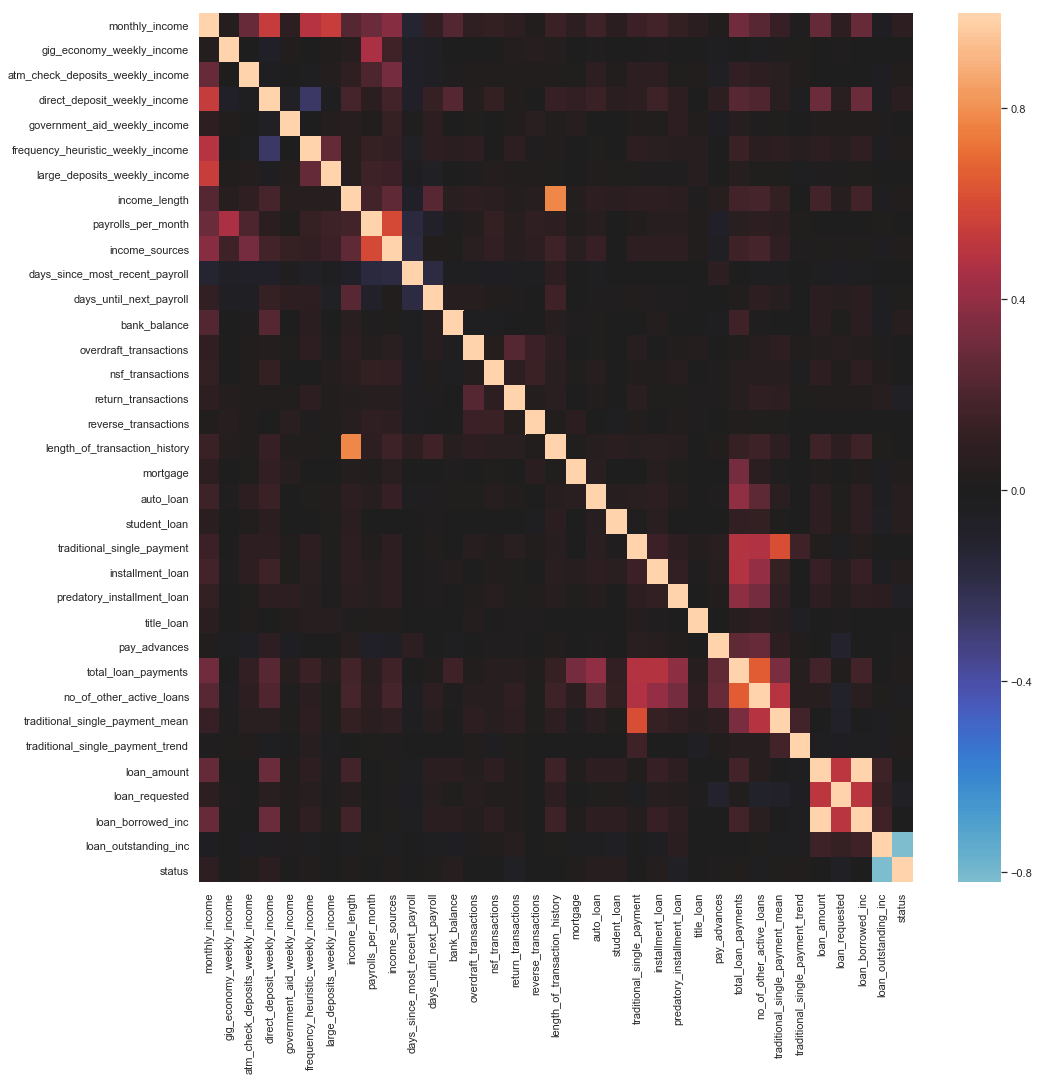

In [1353]:
sns.set(rc={'figure.figsize':(16,16)})
sns.heatmap(df_approved.corr(), center=0);

It is clear that there is some data that reflects event after granting the loan ('loan_amount', 'loan_borrowed', etc.).

There is also hight correlations between length of income and length of transaction history, which asre clearly connected. There are also some intuitive correlations that will be corrected later.

## Check data distributions

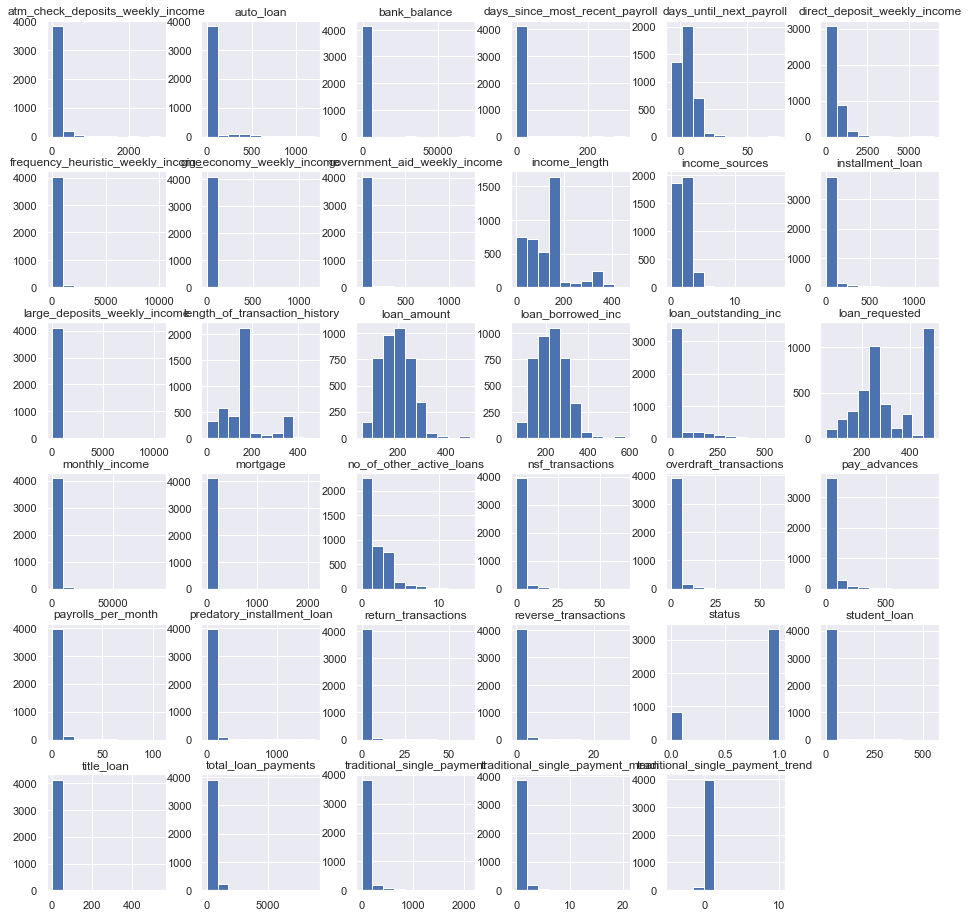

In [1354]:
df_approved.hist();

Distribution is a bit confusing because of the scale of many variables. Some seem to have only 0 values, but it is not the case, as small values are not seen in the histograms.

### Drop columns asocciated with granting the loan: loan_amount, loan_borrowed_inc, loan_outstanding_inc, loan_id

In [1355]:
df_approved = df_approved.drop(['loan_amount', 'loan_borrowed_inc', 'loan_outstanding_inc'], axis=1)
df_rejected = df_rejected.drop(['loan_amount', 'loan_borrowed_inc', 'loan_outstanding_inc'], axis=1)

## Approved loans: train test split
I will work mainly with approved loans in the beginning and use rejected loans a another testing set

In [1356]:
random.seed(113)
y = df_approved['status']
X = df_approved.drop(['status'], axis=1)

#to maintain time order of the appointment date, shuffle is set to False
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### One-hot-encoding

In [1357]:
X_train = ohe(X_train, 'state')
X_test = ohe(X_test, 'state')

In [1358]:
#reset indexes of y-values too (Xs were reset during ohe)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [1359]:
len(y_train) == len(X_train)

True

In [1360]:
df_rejected = ohe(df_rejected, 'state')

### Check for multicollinearity

In [1361]:
correlations = X_train.corr().applymap(lambda x: 'yes' if (abs(x) > 0.8) else x)
#correlations.iloc[:, 0:15]
correlations.iloc[:, 15:]

,return_transactions,reverse_transactions,length_of_transaction_history,mortgage,auto_loan,student_loan,traditional_single_payment,installment_loan,predatory_installment_loan,title_loan,pay_advances,total_loan_payments,no_of_other_active_loans,traditional_single_payment_mean,traditional_single_payment_trend,loan_requested,"state_""ID""","state_""UT""","state_""WA"""
monthly_income,0.0959235,0.0261456,0.124418,0.0891396,0.149521,0.0622194,0.139875,0.155785,0.124164,0.0566299,0.0238492,0.293185,0.229443,0.126495,0.0119687,0.0884726,-0.0226685,-0.0194926,-0.00781726
gig_economy_weekly_income,0.055768,0.0474161,0.0510675,-0.00902228,0.0111329,0.00862688,-0.00110847,0.0120635,-0.0212762,-0.00607679,-0.0355968,-0.0148624,-0.0123885,0.00752418,0.0256891,0.0203209,-0.0047284,-0.0171281,-0.00931342
atm_check_deposits_weekly_income,0.019675,0.0321009,0.0365788,0.0341172,0.089585,0.00110539,0.0668144,0.0434191,0.0259742,0.0423212,-0.0492123,0.0766931,0.0859338,0.067445,0.0281008,-0.015084,-0.0174433,-0.0443903,-0.0393876
direct_deposit_weekly_income,0.0277555,-0.0205495,0.136503,0.113362,0.14211,0.0704092,0.0847351,0.149993,0.0861279,0.000270666,0.070861,0.241969,0.203477,0.0588911,-0.0365428,0.0887686,-0.0505932,-0.015216,0.0117499
government_aid_weekly_income,0.0419974,0.0693665,0.031516,0.0666837,-0.0196553,-0.0115093,0.0395771,0.0210295,0.102511,0.0584214,-0.0401066,0.0581894,0.0130429,0.0153716,-0.00161893,0.0321493,0.0028119,-0.00656444,0.0382366
frequency_heuristic_weekly_income,0.0823179,0.0154,0.011861,-0.0153736,0.0274118,0.00541934,0.0802561,0.0531623,0.06418,0.0377026,-0.00353021,0.131886,0.079692,0.0926676,0.0509697,0.0344969,0.0283421,0.0171923,-0.0174391
large_deposits_weekly_income,0.0356352,0.0328561,0.006512,0.00427656,0.0218859,0.0229811,0.0255364,0.00517067,0.0229178,0.0456072,-0.0126969,0.0426719,0.0337134,0.0240604,-0.00355429,0.00964132,0.00441193,-0.0125722,0.0040899
income_length,0.0534838,0.0561566,0.768752,0.0389893,0.0785592,0.0703334,0.103922,0.079711,0.0788949,0.00518629,0.0755467,0.173793,0.196132,0.125099,-0.0124262,0.0433414,-0.0358735,0.00776493,0.0441425
payrolls_per_month,0.0667542,0.104179,0.0885244,0.0269857,0.0592326,0.00317626,0.0381297,0.0492104,0.0443502,0.0215794,-0.0661711,0.064005,0.0933527,0.0638001,0.0143648,0.00245541,-0.000414905,-0.0213199,-0.0697378
income_sources,0.0650494,0.0861752,0.1499,0.0708647,0.123857,-0.000415352,0.0901223,0.0759836,0.0966147,0.0376106,-0.0561609,0.149677,0.185296,0.0933766,0.00132758,0.024592,0.00538019,0.0117611,-0.0702797


There is high correlation between income_length and length_of_transaction_history. So I decided to drop length_of_transaction_history.

In [1362]:
X_train = X_train.drop('length_of_transaction_history', axis=1)
X_test = X_test.drop('length_of_transaction_history', axis=1)
df_rejected = df_rejected.drop('length_of_transaction_history', axis=1)

### Scaling

Without scaling I could not get consistent coefficient among Logistiv Regression model from Sklearn and StatsModels.

In [1363]:
X_train.head()

,monthly_income,gig_economy_weekly_income,atm_check_deposits_weekly_income,direct_deposit_weekly_income,government_aid_weekly_income,frequency_heuristic_weekly_income,large_deposits_weekly_income,income_length,payrolls_per_month,income_sources,...,title_loan,pay_advances,total_loan_payments,no_of_other_active_loans,traditional_single_payment_mean,traditional_single_payment_trend,loan_requested,"state_""ID""","state_""UT""","state_""WA"""
0,2174.54,0.0,0.0,543.6350,0.0,0.000,0.0,157,2.166667,1,...,0.0,0.0,269.68,2,1.000000,1.775886e-16,150.0,0.0,0.0,1.0
1,2949.95,0.0,0.0,737.4875,0.0,0.000,0.0,168,2.166667,1,...,0.0,0.0,268.71,4,0.000000,0.000000e+00,500.0,0.0,0.0,1.0
2,2750.22,0.0,0.0,0.0000,0.0,687.555,0.0,26,2.000000,1,...,0.0,0.0,97.69,2,0.000000,0.000000e+00,255.0,0.0,0.0,0.0
3,4200.06,0.0,160.0,890.0150,0.0,0.000,0.0,167,6.000000,3,...,0.0,0.0,550.00,2,3.666667,1.090477e-12,255.0,0.0,0.0,0.0
4,1993.28,0.0,0.0,498.3200,0.0,0.000,0.0,81,1.500000,1,...,0.0,0.0,327.16,2,1.000000,0.000000e+00,325.0,0.0,1.0,0.0


In [1364]:
X_train.columns

Index(['monthly_income', 'gig_economy_weekly_income',
       'atm_check_deposits_weekly_income', 'direct_deposit_weekly_income',
       'government_aid_weekly_income', 'frequency_heuristic_weekly_income',
       'large_deposits_weekly_income', 'income_length', 'payrolls_per_month',
       'income_sources', 'days_since_most_recent_payroll',
       'days_until_next_payroll', 'bank_balance', 'overdraft_transactions',
       'nsf_transactions', 'return_transactions', 'reverse_transactions',
       'mortgage', 'auto_loan', 'student_loan', 'traditional_single_payment',
       'installment_loan', 'predatory_installment_loan', 'title_loan',
       'pay_advances', 'total_loan_payments', 'no_of_other_active_loans',
       'traditional_single_payment_mean', 'traditional_single_payment_trend',
       'loan_requested', 'state_"ID"', 'state_"UT"', 'state_"WA"'],
      dtype='object')

In [1365]:
binary_columns = X_train[['state_\"ID\"', 'state_\"UT\"', 'state_\"WA\"']]

In [1366]:
X_train_c = X_train.drop(['state_\"ID\"', 'state_\"UT\"', 'state_\"WA\"'], axis=1)

In [1367]:
ss = StandardScaler()
ss.fit(X_train_c)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [1368]:
#scale X_train
X_train_scaled = ss.transform(X_train_c)

In [1369]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = ['monthly_income', 'gig_economy_weekly_income',
       'atm_check_deposits_weekly_income', 'direct_deposit_weekly_income',
       'government_aid_weekly_income', 'frequency_heuristic_weekly_income',
       'large_deposits_weekly_income', 'income_length', 'payrolls_per_month',
       'income_sources', 'days_since_most_recent_payroll',
       'days_until_next_payroll', 'bank_balance', 'overdraft_transactions',
       'nsf_transactions', 'return_transactions', 'reverse_transactions',
       'mortgage', 'auto_loan', 'student_loan', 'traditional_single_payment',
       'installment_loan', 'predatory_installment_loan', 'title_loan',
       'pay_advances', 'total_loan_payments', 'no_of_other_active_loans',
       'traditional_single_payment_mean', 'traditional_single_payment_trend',
       'loan_requested'])

In [1370]:
X_train_scaled = pd.concat([X_train_scaled, binary_columns], axis=1, join='inner') 

In [1371]:
X_train_scaled.head()

,monthly_income,gig_economy_weekly_income,atm_check_deposits_weekly_income,direct_deposit_weekly_income,government_aid_weekly_income,frequency_heuristic_weekly_income,large_deposits_weekly_income,income_length,payrolls_per_month,income_sources,...,title_loan,pay_advances,total_loan_payments,no_of_other_active_loans,traditional_single_payment_mean,traditional_single_payment_trend,loan_requested,"state_""ID""","state_""UT""","state_""WA"""
0,-0.237297,-0.119097,-0.383458,0.227363,-0.135623,-0.377722,-0.133784,0.244116,-0.432541,-0.732181,...,-0.051024,-0.34078,0.140532,0.172273,0.434033,-0.049789,-1.204645,0.0,0.0,1.0
1,0.063139,-0.119097,-0.383458,0.646109,-0.135623,-0.377722,-0.133784,0.367800,-0.432541,-0.732181,...,-0.051024,-0.34078,0.138142,1.325283,-0.366729,-0.049789,1.330281,0.0,0.0,1.0
2,-0.014247,-0.119097,-0.383458,-0.946957,-0.135623,1.425085,-0.133784,-1.228844,-0.470645,-0.732181,...,-0.051024,-0.34078,-0.283183,0.172273,-0.366729,-0.049789,-0.444167,0.0,0.0,0.0
3,0.547500,-0.119097,0.534312,0.975588,-0.135623,-0.377722,-0.133784,0.356556,0.443845,1.066645,...,-0.051024,-0.34078,0.831128,0.172273,2.569399,-0.049789,-0.444167,0.0,0.0,0.0
4,-0.307527,-0.119097,-0.383458,0.129477,-0.135623,-0.377722,-0.133784,-0.610426,-0.584956,-0.732181,...,-0.051024,-0.34078,0.282139,0.172273,0.434033,-0.049789,0.062818,0.0,1.0,0.0


In [1372]:
#scale X_test
binary_columns = X_test[['state_\"ID\"', 'state_\"UT\"', 'state_\"WA\"']]
X_test_c = X_test.drop(['state_\"ID\"', 'state_\"UT\"', 'state_\"WA\"'], axis=1)
X_test_scaled = ss.transform(X_test_c)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = ['monthly_income', 'gig_economy_weekly_income',
       'atm_check_deposits_weekly_income', 'direct_deposit_weekly_income',
       'government_aid_weekly_income', 'frequency_heuristic_weekly_income',
       'large_deposits_weekly_income', 'income_length', 'payrolls_per_month',
       'income_sources', 'days_since_most_recent_payroll',
       'days_until_next_payroll', 'bank_balance', 'overdraft_transactions',
       'nsf_transactions', 'return_transactions', 'reverse_transactions',
       'mortgage', 'auto_loan', 'student_loan', 'traditional_single_payment',
       'installment_loan', 'predatory_installment_loan', 'title_loan',
       'pay_advances', 'total_loan_payments', 'no_of_other_active_loans',
       'traditional_single_payment_mean', 'traditional_single_payment_trend',
       'loan_requested'])

X_test_scaled = pd.concat([X_test_scaled, binary_columns], axis=1, join='inner') 

X_test_scaled.head()

,monthly_income,gig_economy_weekly_income,atm_check_deposits_weekly_income,direct_deposit_weekly_income,government_aid_weekly_income,frequency_heuristic_weekly_income,large_deposits_weekly_income,income_length,payrolls_per_month,income_sources,...,title_loan,pay_advances,total_loan_payments,no_of_other_active_loans,traditional_single_payment_mean,traditional_single_payment_trend,loan_requested,"state_""ID""","state_""UT""","state_""WA"""
0,2.015481,-0.119097,-0.383458,-0.946957,-0.135623,4.859073,-0.133784,2.054395,-0.470645,-0.732181,...,-0.051024,-0.340780,-0.523852,-0.980737,0.534129,0.037125,1.330281,0.0,0.0,1.0
1,-0.595278,-0.119097,-0.383458,-0.271588,-0.135623,-0.377722,-0.133784,-0.351814,-0.070556,0.167232,...,-0.051024,0.548022,-0.339082,-0.404232,-0.366729,-0.049789,-0.118248,0.0,1.0,0.0
2,-0.477562,-0.119097,-0.383458,-0.107516,-0.135623,-0.377722,-0.133784,-1.307552,-0.699268,-0.732181,...,-0.051024,-0.340780,-0.523852,-0.980737,-0.366729,-0.049789,-0.480380,0.0,0.0,1.0
3,2.080027,-0.119097,-0.067974,-0.946957,-0.135623,2.735149,3.126843,1.953199,0.081859,1.066645,...,59.354797,-0.340780,1.575283,1.325283,-0.366729,-0.049789,1.330281,0.0,1.0,0.0
4,0.849886,5.727790,1.220990,-0.946957,-0.135623,1.392166,-0.133784,0.570191,4.407724,1.966058,...,-0.051024,-0.340780,-0.404983,0.748778,6.439748,2.383810,-0.444167,0.0,0.0,0.0


### FSM: Logistic regression

In [1373]:
#pipe = Pipeline(steps=[
    
#    ('classifier', LogisticRegression(solver='lbfgs', n_jobs=-1))
#])
#pipe.fit(X_train, y_train)

In [1374]:
models = []
reports = []

In [1375]:
lr1, report_lr1 = logireg(X_train_scaled, X_test_scaled, y_train, y_test)

Report:
              precision    recall  f1-score   support

           0       0.40      0.12      0.19       170
           1       0.81      0.95      0.87       659

    accuracy                           0.78       829
   macro avg       0.60      0.54      0.53       829
weighted avg       0.72      0.78      0.73       829
 CV score: 0.5913451987318175

Each Cross Validated Accuracy: 
 [0.65686275 0.62433155 0.55280749 0.6290107  0.49371352]

Overall Classifier Accuracy: 0.59 (+/- 0.12)



In [1376]:
models.append(lr1)
reports.append(report_lr1)

In [1377]:
#extract coefficients
coef = list(lr.coef_[0])
coef

[0.19653129267875385,
 0.045015762100391675,
 0.09450591992609313,
 0.1429770599759819,
 -0.013156215034564642,
 0.17650417362426213,
 -0.1022162735674343,
 0.004917729437227297,
 -0.1170216498428271,
 0.036427380083436024,
 0.07853942869272636,
 0.07389348445208378,
 1.267674382405232,
 -0.018012941542217095,
 -0.036314809695757316,
 -0.15297070468427929,
 -0.02266156271129966,
 0.15291705451714369,
 0.18292884600834547,
 0.2653606859287958,
 -0.050774618031540215,
 0.16053456473201838,
 -0.07157549469186837,
 0.050856547748667866,
 0.09477244747089014,
 0.006232964841627297,
 -0.3312744432354233,
 0.2297824584589456,
 0.044448668769626505,
 -0.24849575101197072,
 0.24108858045885306,
 -0.5291012765341749,
 0.29327577209476485]

In [1378]:
feature_names = X_test.columns
features = pd.DataFrame()
features['name'] = feature_names
features['coef'] = coef

In [1379]:
features

,name,coef
0,monthly_income,0.196531
1,gig_economy_weekly_income,0.045016
2,atm_check_deposits_weekly_income,0.094506
3,direct_deposit_weekly_income,0.142977
4,government_aid_weekly_income,-0.013156
5,frequency_heuristic_weekly_income,0.176504
6,large_deposits_weekly_income,-0.102216
7,income_length,0.004918
8,payrolls_per_month,-0.117022
9,income_sources,0.036427


### Compare with StatsModels model

In [1380]:
logit_model=sm.Logit(y_train, X_train_scaled, random_state=113)
result=logit_model.fit(maxiter=100)
print(result.summary())

         Current function value: 0.501134
         Iterations: 100
                           Logit Regression Results                           
Dep. Variable:                 status   No. Observations:                 3313
Model:                          Logit   Df Residuals:                     3281
Method:                           MLE   Df Model:                           31
Date:                Wed, 03 Jul 2019   Pseudo R-squ.:               -0.006191
Time:                        10:02:26   Log-Likelihood:                -1660.3
converged:                      False   LL-Null:                       -1650.0
                                        LLR p-value:                     1.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
monthly_income                        0.1226   1.78e+06   6.87e-08      1.000    -3.5e+06     3.5

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



### Try logistic regression with the coefficients that have p-values < 0.05

In [1381]:
X_train_mod = X_train[['bank_balance', 'auto_loan', 'student_loan',
                                     'installment_loan', 'pay_advances', 'traditional_single_payment_mean', 
                                    'loan_requested', 'state_\"ID\"', 'state_\"UT\"', 'state_\"WA\"']]
X_test_mod = X_test[['bank_balance', 'auto_loan', 'student_loan',
                                     'installment_loan', 'pay_advances', 'traditional_single_payment_mean', 
                                    'loan_requested', 'state_\"ID\"', 'state_\"UT\"', 'state_\"WA\"']]

In [1382]:
#fit and transform train
binary_columns = X_train_mod[['state_\"ID\"', 'state_\"UT\"', 'state_\"WA\"']]
X_train_mod_c = X_train_mod.drop(['state_\"ID\"', 'state_\"UT\"', 'state_\"WA\"'], axis=1)
ss.fit(X_train_mod_c)
X_train_mod_scaled = ss.transform(X_train_mod_c)
X_train_mod_scaled = pd.DataFrame(X_train_mod_scaled, columns = ['bank_balance', 
                                                                 'auto_loan', 'student_loan',
                                                                'installment_loan', 'pay_advances', 
                                                                 'traditional_single_payment_mean', 
                                                                'loan_requested'])
X_train_mod_scaled = pd.concat([X_train_mod_scaled, binary_columns], axis=1, join='inner')
                                  
#transfrm test set

binary_columns = X_test_mod[['state_\"ID\"', 'state_\"UT\"', 'state_\"WA\"']]
X_test_mod_c = X_test_mod.drop(['state_\"ID\"', 'state_\"UT\"', 'state_\"WA\"'], axis=1)
X_test_mod_scaled = ss.transform(X_test_mod_c)
X_test_mod_scaled = pd.DataFrame(X_test_mod_scaled, columns = ['bank_balance', 
                                                                 'auto_loan', 'student_loan',
                                                                'installment_loan', 'pay_advances', 
                                                                 'traditional_single_payment_mean', 
                                                                'loan_requested'])
X_test_mod_scaled = pd.concat([X_test_mod_scaled, binary_columns], axis=1, join='inner')

StandardScaler(copy=True, with_mean=True, with_std=True)

In [1383]:
lr2, report_lr2 = logireg(X_train_mod_scaled, X_test_mod_scaled, y_train, y_test)

Report:
              precision    recall  f1-score   support

           0       0.35      0.12      0.18       170
           1       0.81      0.94      0.87       659

    accuracy                           0.77       829
   macro avg       0.58      0.53      0.52       829
weighted avg       0.71      0.77      0.73       829
 CV score: 0.6009504565184853

Each Cross Validated Accuracy: 
 [0.64293672 0.62990196 0.58132799 0.61151961 0.53906601]

Overall Classifier Accuracy: 0.60 (+/- 0.07)



In [1384]:
models.append(lr2)
reports.append(report_lr2)

In [1385]:
#extract coefficients
coef = list(lr2.coef_[0])
coef

[1.0246669880545036,
 0.12709613091296482,
 0.2060447646610892,
 0.11496009478660424,
 0.12252606790325356,
 0.17483964889936848,
 -0.5569978158214566,
 1.3628333869829516,
 1.0862232019450302,
 1.9690001592696627]

In [1386]:
feature_names = X_test_mod.columns
features = pd.DataFrame()
features['name'] = feature_names
features['coef'] = coef

In [1387]:
features

,name,coef
0,bank_balance,1.024667
1,auto_loan,0.127096
2,student_loan,0.206045
3,installment_loan,0.114960
4,pay_advances,0.122526
5,traditional_single_payment_mean,0.174840
6,loan_requested,-0.556998
7,"state_""ID""",1.362833
8,"state_""UT""",1.086223
9,"state_""WA""",1.969000


In [1388]:
logit_model=sm.Logit(y_train, X_train_mod_scaled, random_state=113)
result=logit_model.fit(maxiter=100)
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.509083
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 status   No. Observations:                 3313
Model:                          Logit   Df Residuals:                     3303
Method:                           MLE   Df Model:                            9
Date:                Wed, 03 Jul 2019   Pseudo R-squ.:                -0.02215
Time:                        10:02:29   Log-Likelihood:                -1686.6
converged:                       True   LL-Null:                       -1650.0
                                        LLR p-value:                     1.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
bank_balance                        1.0245      0.182      5.641  

### Random forest

In [1389]:
rfc1, report_rfc1 = rf(X_train, X_test, y_train, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=113,
                       verbose=0, warm_start=False)
Report:
              precision    recall  f1-score   support

           0       0.50      0.05      0.09       170
           1       0.80      0.99      0.88       659

    accuracy                           0.79       829
   macro avg       0.65      0.52      0.49       829
weighted avg       0.74      0.79      0.72       829
 CV score: 0.6108533698003837

Each Cross Validated Accuracy: 
 [0.6589795  0.60282977 0.60138146 0.64549911 0.54557701]

Overall Classifier Accuracy: 0.61 (+/- 0.08)



In [1390]:
models.append(rfc1)
reports.append(report_rfc1)

## XG Boost

In [1391]:
xgb1, report_xgb1= xgb(X_train, X_test, y_train, y_test)

Report:
              precision    recall  f1-score   support

           0       0.50      0.04      0.08       170
           1       0.80      0.99      0.88       659

    accuracy                           0.79       829
   macro avg       0.65      0.52      0.48       829
weighted avg       0.74      0.79      0.72       829
 CV score: 0.6201721979562124

Each Cross Validated Accuracy: 
 [0.64237968 0.5802139  0.58444742 0.65663993 0.63718006]

Overall Classifier Accuracy: 0.62 (+/- 0.06)



In [1392]:
models.append(xgb1)
reports.append(report_xgb1)

## Gradient Boost

In [1393]:
gb1, report_gb1 = gb(X_train, X_test, y_train, y_test)

Report:
              precision    recall  f1-score   support

           0       0.54      0.04      0.08       170
           1       0.80      0.99      0.89       659

    accuracy                           0.80       829
   macro avg       0.67      0.52      0.48       829
weighted avg       0.75      0.80      0.72       829
 CV score: 0.5876956021825801

Each Cross Validated Accuracy: 
 [0.58934938 0.57687166 0.56561943 0.60695187 0.59968568]

Overall Classifier Accuracy: 0.59 (+/- 0.03)



In [1394]:
models.append(gb1)
reports.append(report_gb1)

### Conclusion after trying dofferent models: it seems that all models fail to perform on 0 class because of the class imbalance. Next step: correct class imbalance. Best model so far: random forests

## New approach to correct class imbalance

The current training set has 2649 class 1 values and 664 class 0 values. To correct class imbalance I will treat the rejected applications subset as class 0. I will randomly pick 2000 rejected applications and add them to the training set. I will then test the new model (random forest as it seems to have the best performance) on the original testing set that has true labels.

In [1395]:
# Get random 2000 values from rejected dataset 

rejected_subset = df_rejected.sample(n=2000)

In [1396]:
len(rejected_subset)

2000

In [1397]:
# Isolate target column

y_subset_0 = rejected_subset['status']
X_subset_0 = rejected_subset.drop('status', axis=1)

In [1398]:
# Doublecheck if the columns correspond
X_train.columns == X_subset_0.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [1399]:
new_X_train = X_train.append(X_subset_0)

In [1400]:
new_y_train = y_train.append(y_subset_0)

### Train random forests on the new training set

In [1401]:
rfc2, report_rfc2 = rf(new_X_train, X_test, new_y_train, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=113,
                       verbose=0, warm_start=False)
Report:
              precision    recall  f1-score   support

           0       0.31      0.51      0.38       170
           1       0.85      0.70      0.77       659

    accuracy                           0.66       829
   macro avg       0.58      0.60      0.58       829
weighted avg       0.74      0.66      0.69       829
 CV score: 0.6108533698003837

Each Cross Validated Accuracy: 
 [0.6589795  0.60282977 0.60138146 0.64549911 0.54557701]

Overall Classifier Accuracy: 0.61 (+/- 0.08)



In [1402]:
models.append(rfc2)
reports.append(report_rfc2)

## Comparison of the evaluation scores 

|model| CV score  |precision 0   | precision 1  | recall 0  | recall 1  | f1 0 | f1 1 |
|---|---|---|---|---|---|---|---|
|Logistic regression (scaled) | 0.79  | 0.21  | 0.81  | 0.09  | 0.92 | 0.12 | 0.86 |
|Logistic Regression limited features (scaled)| 0.77  | 0.21  | 0.81 |  0.06 | 0.94 | 0.10 | 0.87 |
|Random forest | 0.80  | 0.38  | 0.81  |  0.06 | 0.98 | 0.11 | 0.89 |
|XGBoost | 0.79 | 0.65 | 0.82 | 0.07 | 0.99 | 0.12 | 0.89 |
|Gradient Boosting | 0.80 | 0.44 | 0.81 | 0.02 | 0.99 | 0.05 | 0.89 |
|Random forest with data from rejected dataset | 0.80 | 0.25 | 0.83 | 0.40 | 0.71 | 0.31 | 0.77 |
|Logistic regression with data from rejected dataset (scaled) | 0.79 | 0.24 | 0.83 | 0.42 | 0.68 | 0.31 | 0.75 | 

### Try logistic regression on my new training set

In [1403]:
#scale the new dataset

ss2 = StandardScaler()

#fit and transform train
binary_columns = new_X_train[['state_\"ID\"', 'state_\"UT\"', 'state_\"WA\"']]
len(binary_columns)

5313

In [1404]:
new_X_train_c = new_X_train.drop(['state_\"ID\"', 'state_\"UT\"', 'state_\"WA\"'], axis=1)
len(new_X_train_c)

5313

In [1405]:
ss2.fit(new_X_train_c)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [1406]:
new_X_train_scaled = ss2.transform(new_X_train_c)
len(new_X_train_scaled)

5313

In [1407]:
new_X_train_scaled = pd.DataFrame(new_X_train_scaled, columns = ['monthly_income', 'gig_economy_weekly_income',
       'atm_check_deposits_weekly_income', 'direct_deposit_weekly_income',
       'government_aid_weekly_income', 'frequency_heuristic_weekly_income',
       'large_deposits_weekly_income', 'income_length', 'payrolls_per_month',
       'income_sources', 'days_since_most_recent_payroll',
       'days_until_next_payroll', 'bank_balance', 'overdraft_transactions',
       'nsf_transactions', 'return_transactions', 'reverse_transactions',
       'mortgage', 'auto_loan', 'student_loan', 'traditional_single_payment',
       'installment_loan', 'predatory_installment_loan', 'title_loan',
       'pay_advances', 'total_loan_payments', 'no_of_other_active_loans',
       'traditional_single_payment_mean', 'traditional_single_payment_trend',
       'loan_requested'])
len(new_X_train_scaled)

5313

In [1408]:
new_X_train_scaled = new_X_train_scaled.reset_index(drop=True)
binary_columns = binary_columns.reset_index(drop=True)

In [1409]:
new_X_train_scaled = pd.concat([new_X_train_scaled, binary_columns], axis=1, join='inner')

In [1410]:
new_X_train_scaled.head()

,monthly_income,gig_economy_weekly_income,atm_check_deposits_weekly_income,direct_deposit_weekly_income,government_aid_weekly_income,frequency_heuristic_weekly_income,large_deposits_weekly_income,income_length,payrolls_per_month,income_sources,...,title_loan,pay_advances,total_loan_payments,no_of_other_active_loans,traditional_single_payment_mean,traditional_single_payment_trend,loan_requested,"state_""ID""","state_""UT""","state_""WA"""
0,-0.088866,-0.114689,-0.37856,0.412555,-0.136265,-0.337442,-0.151427,0.405637,-0.347364,-0.547458,...,-0.049533,-0.303521,0.159362,0.222133,0.422373,-0.059014,-1.246629,0.0,0.0,1.0
1,0.221910,-0.114689,-0.37856,0.847977,-0.136265,-0.337442,-0.151427,0.522098,-0.347364,-0.547458,...,-0.049533,-0.303521,0.156971,1.346663,-0.373604,-0.059014,1.274723,0.0,0.0,1.0
2,0.141861,-0.114689,-0.37856,-0.808532,-0.136265,1.637794,-0.151427,-0.981306,-0.385074,-0.547458,...,-0.049533,-0.303521,-0.264633,0.222133,-0.373604,-0.059014,-0.490223,0.0,0.0,0.0
3,0.722942,-0.114689,0.46838,1.190577,-0.136265,-0.337442,-0.151427,0.511511,0.519971,1.163007,...,-0.049533,-0.303521,0.850416,0.222133,2.544981,-0.059014,-0.490223,0.0,0.0,0.0
4,-0.161513,-0.114689,-0.37856,0.310771,-0.136265,-0.337442,-0.151427,-0.399001,-0.498205,-0.547458,...,-0.049533,-0.303521,0.301063,0.222133,0.422373,-0.059014,0.014047,0.0,1.0,0.0


In [1411]:
#transfrm test set

binary_columns = X_test[['state_\"ID\"', 'state_\"UT\"', 'state_\"WA\"']]
X_test_c = X_test.drop(['state_\"ID\"', 'state_\"UT\"', 'state_\"WA\"'], axis=1)

new_X_test_scaled = ss2.transform(X_test_c)
new_X_test_scaled = pd.DataFrame(new_X_test_scaled, columns = ['monthly_income', 'gig_economy_weekly_income',
       'atm_check_deposits_weekly_income', 'direct_deposit_weekly_income',
       'government_aid_weekly_income', 'frequency_heuristic_weekly_income',
       'large_deposits_weekly_income', 'income_length', 'payrolls_per_month',
       'income_sources', 'days_since_most_recent_payroll',
       'days_until_next_payroll', 'bank_balance', 'overdraft_transactions',
       'nsf_transactions', 'return_transactions', 'reverse_transactions',
       'mortgage', 'auto_loan', 'student_loan', 'traditional_single_payment',
       'installment_loan', 'predatory_installment_loan', 'title_loan',
       'pay_advances', 'total_loan_payments', 'no_of_other_active_loans',
       'traditional_single_payment_mean', 'traditional_single_payment_trend',
       'loan_requested'])

new_X_test_scaled = new_X_test_scaled.reset_index(drop=True)
binary_columns = binary_columns.reset_index(drop=True)

new_X_test_scaled = pd.concat([new_X_test_scaled, binary_columns], axis=1, join='inner')

In [1412]:
#apply logistic regression

lr3, report_lr3 = logireg(new_X_train_scaled, new_X_test_scaled, new_y_train, y_test)

Report:
              precision    recall  f1-score   support

           0       0.26      0.46      0.33       170
           1       0.83      0.67      0.74       659

    accuracy                           0.62       829
   macro avg       0.54      0.56      0.54       829
weighted avg       0.71      0.62      0.66       829
 CV score: 0.5947034330734375

Each Cross Validated Accuracy: 
 [0.65329768 0.64104278 0.56238859 0.61252228 0.50426583]

Overall Classifier Accuracy: 0.59 (+/- 0.11)



In [1413]:
models.append(lr3)
reports.append(report_lr3)

### Try Gradient Boosting on my new training set

In [1414]:
gb2, report_gb2 = gb(new_X_train, X_test, new_y_train, y_test)

Report:
              precision    recall  f1-score   support

           0       0.26      0.36      0.30       170
           1       0.82      0.73      0.77       659

    accuracy                           0.66       829
   macro avg       0.54      0.55      0.54       829
weighted avg       0.70      0.66      0.68       829
 CV score: 0.5876956021825801

Each Cross Validated Accuracy: 
 [0.58934938 0.57687166 0.56561943 0.60695187 0.59968568]

Overall Classifier Accuracy: 0.59 (+/- 0.03)



In [1415]:
models.append(gb2)
reports.append(report_gb2)

### Try XGBoost  regression on my new training set

In [1416]:
xgb2, report_xgb2 = xgb(new_X_train, X_test, new_y_train, y_test)

Report:
              precision    recall  f1-score   support

           0       0.27      0.39      0.32       170
           1       0.82      0.73      0.77       659

    accuracy                           0.66       829
   macro avg       0.55      0.56      0.55       829
weighted avg       0.71      0.66      0.68       829
 CV score: 0.6201721979562124

Each Cross Validated Accuracy: 
 [0.64237968 0.5802139  0.58444742 0.65663993 0.63718006]

Overall Classifier Accuracy: 0.62 (+/- 0.06)



In [1417]:
models.append(xgb2)
reports.append(report_xgb2)

## Comparison of the evaluation scores

|model| CV score  |precision 0   | precision 1  | recall 0  | recall 1  | f1 0 | f1 1 |
|---|---|---|---|---|---|---|---|
|Logistic regression (scaled) | 0.79  | 0.21  | 0.81  | 0.09  | 0.92 | 0.12 | 0.86 |
|Logistic Regression limited features (scaled)| 0.77  | 0.21  | 0.81 |  0.06 | 0.94 | 0.10 | 0.87 |
|Random forest | 0.80  | 0.38  | 0.81  |  0.06 | 0.98 | 0.11 | 0.89 |
|XGBoost | 0.79 | 0.65 | 0.82 | 0.07 | 0.99 | 0.12 | 0.89 |
|Gradient Boosting | 0.80 | 0.44 | 0.81 | 0.02 | 0.99 | 0.05 | 0.89 |
|Random forest with data from rejected dataset | 0.80 | 0.25 | 0.83 | 0.40 | 0.71 | 0.31 | 0.77 |
|Logistic regression with data from rejected dataset (scaled) | 0.79 | 0.24 | 0.83 | 0.42 | 0.68 | 0.31 | 0.75 | 
|Gradient Boosting with data from rejected dataset | 0.80 | 0.23 | 0.82 | 0.33 | 0.74 | 0.27 | 0.78 |
|XG Boost with data from rejected dataset | 0.79 | 0.26 | 0.84 | 0.41 | 0.82 | 0.32 | 0.78 |

## Correcting class imbalance with Sklearn resample

In [1418]:
training_set = X_train.copy()

In [1419]:
training_set['status'] = y_train

In [1420]:
training_set.head()

,monthly_income,gig_economy_weekly_income,atm_check_deposits_weekly_income,direct_deposit_weekly_income,government_aid_weekly_income,frequency_heuristic_weekly_income,large_deposits_weekly_income,income_length,payrolls_per_month,income_sources,...,pay_advances,total_loan_payments,no_of_other_active_loans,traditional_single_payment_mean,traditional_single_payment_trend,loan_requested,"state_""ID""","state_""UT""","state_""WA""",status
0,2174.54,0.0,0.0,543.6350,0.0,0.000,0.0,157,2.166667,1,...,0.0,269.68,2,1.000000,1.775886e-16,150.0,0.0,0.0,1.0,1
1,2949.95,0.0,0.0,737.4875,0.0,0.000,0.0,168,2.166667,1,...,0.0,268.71,4,0.000000,0.000000e+00,500.0,0.0,0.0,1.0,1
2,2750.22,0.0,0.0,0.0000,0.0,687.555,0.0,26,2.000000,1,...,0.0,97.69,2,0.000000,0.000000e+00,255.0,0.0,0.0,0.0,1
3,4200.06,0.0,160.0,890.0150,0.0,0.000,0.0,167,6.000000,3,...,0.0,550.00,2,3.666667,1.090477e-12,255.0,0.0,0.0,0.0,1
4,1993.28,0.0,0.0,498.3200,0.0,0.000,0.0,81,1.500000,1,...,0.0,327.16,2,1.000000,0.000000e+00,325.0,0.0,1.0,0.0,1


In [1421]:
training_set_0 = training_set.loc[training_set.status == 0]

In [1422]:
training_set_0.status.value_counts()

0    657
Name: status, dtype: int64

In [1423]:
training_set_0_upsampled = resample(training_set_0, replace=True, n_samples=2000, random_state=0)

In [1424]:
len(training_set_0_upsampled)

2000

In [1425]:
y_training_set_0_upsampled = training_set_0_upsampled['status']
X_training_set_0_upsampled = training_set_0_upsampled.drop('status', axis=1)

In [1426]:
X_training_set_0_upsampled.head()

,monthly_income,gig_economy_weekly_income,atm_check_deposits_weekly_income,direct_deposit_weekly_income,government_aid_weekly_income,frequency_heuristic_weekly_income,large_deposits_weekly_income,income_length,payrolls_per_month,income_sources,...,title_loan,pay_advances,total_loan_payments,no_of_other_active_loans,traditional_single_payment_mean,traditional_single_payment_trend,loan_requested,"state_""ID""","state_""UT""","state_""WA"""
2830,1719.14,0.0,88.0,0.0000,0.0,341.785,0.0,320,3.818182,2,...,0.0,0.0,0.00,0,1.285714,-0.036184,50.0,0.0,0.0,1.0
3162,1487.76,0.0,60.0,0.0000,0.0,311.940,0.0,168,6.166667,3,...,0.0,0.0,0.00,0,0.000000,0.000000,400.0,0.0,0.0,1.0
970,0.00,0.0,0.0,0.0000,0.0,0.000,0.0,0,0.000000,0,...,0.0,0.0,70.98,5,0.000000,0.000000,500.0,0.0,0.0,1.0
1783,2226.80,0.0,54.0,0.0000,502.7,0.000,0.0,358,5.384615,2,...,0.0,0.0,0.00,1,0.000000,0.000000,500.0,0.0,0.0,1.0
46,2014.93,0.0,0.0,503.7325,0.0,0.000,0.0,58,2.000000,1,...,0.0,0.0,0.00,0,0.000000,0.000000,150.0,0.0,0.0,1.0


In [1427]:
new_X_train_upsampled = X_train.append(X_training_set_0_upsampled)
new_y_train_upsampled = y_train.append(y_training_set_0_upsampled)

In [1428]:
len(new_X_train_upsampled)

5313

### Apply random forest

In [1429]:
rf3, report_rf3 = rf(new_X_train_upsampled, X_test, new_y_train_upsampled, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=113,
                       verbose=0, warm_start=False)
Report:
              precision    recall  f1-score   support

           0       0.44      0.15      0.23       170
           1       0.81      0.95      0.88       659

    accuracy                           0.79       829
   macro avg       0.63      0.55      0.55       829
weighted avg       0.74      0.79      0.74       829
 CV score: 0.6108533698003837

Each Cross Validated Accuracy: 
 [0.6589795  0.60282977 0.60138146 0.64549911 0.54557701]

Overall Classifier Accuracy: 0.61 (+/- 0.08)



### Gradient boosting

In [1430]:
gb3, report_gb3 = gb(new_X_train_upsampled, X_test, new_y_train_upsampled, y_test)

Report:
              precision    recall  f1-score   support

           0       0.32      0.56      0.41       170
           1       0.86      0.69      0.77       659

    accuracy                           0.67       829
   macro avg       0.59      0.63      0.59       829
weighted avg       0.75      0.67      0.70       829
 CV score: 0.5876956021825801

Each Cross Validated Accuracy: 
 [0.58934938 0.57687166 0.56561943 0.60695187 0.59968568]

Overall Classifier Accuracy: 0.59 (+/- 0.03)



### XGBoost

In [1431]:
xgb3, report_xgb3 = xgb(new_X_train_upsampled, X_test, new_y_train_upsampled, y_test)

Report:
              precision    recall  f1-score   support

           0       0.31      0.56      0.40       170
           1       0.86      0.69      0.76       659

    accuracy                           0.66       829
   macro avg       0.59      0.62      0.58       829
weighted avg       0.75      0.66      0.69       829
 CV score: 0.6201721979562124

Each Cross Validated Accuracy: 
 [0.64237968 0.5802139  0.58444742 0.65663993 0.63718006]

Overall Classifier Accuracy: 0.62 (+/- 0.06)



### Logistic regression

In [1432]:
# Scaling
#train set
ss3 = StandardScaler()

binary_columns = new_X_train_upsampled[['state_\"ID\"', 'state_\"UT\"', 'state_\"WA\"']]

new_X_train_upsampled_c = new_X_train_upsampled.drop(['state_\"ID\"', 'state_\"UT\"', 'state_\"WA\"'], axis=1)

ss3.fit(new_X_train_upsampled_c)

new_X_train_upsampled_scaled = ss3.transform(new_X_train_upsampled_c)

new_X_train_upsampled_scaled = pd.DataFrame(new_X_train_upsampled_scaled, columns = ['monthly_income', 'gig_economy_weekly_income',
       'atm_check_deposits_weekly_income', 'direct_deposit_weekly_income',
       'government_aid_weekly_income', 'frequency_heuristic_weekly_income',
       'large_deposits_weekly_income', 'income_length', 'payrolls_per_month',
       'income_sources', 'days_since_most_recent_payroll',
       'days_until_next_payroll', 'bank_balance', 'overdraft_transactions',
       'nsf_transactions', 'return_transactions', 'reverse_transactions',
       'mortgage', 'auto_loan', 'student_loan', 'traditional_single_payment',
       'installment_loan', 'predatory_installment_loan', 'title_loan',
       'pay_advances', 'total_loan_payments', 'no_of_other_active_loans',
       'traditional_single_payment_mean', 'traditional_single_payment_trend',
       'loan_requested'])
new_X_train_upsampled_scaled = new_X_train_upsampled_scaled.reset_index(drop=True)
binary_columns = binary_columns.reset_index(drop=True)
new_X_train_upsampled_scaled = pd.concat([new_X_train_upsampled_scaled, binary_columns], axis=1, join='inner')


StandardScaler(copy=True, with_mean=True, with_std=True)

In [1433]:
#test set

binary_columns = X_test[['state_\"ID\"', 'state_\"UT\"', 'state_\"WA\"']]

X_test_c = X_test.drop(['state_\"ID\"', 'state_\"UT\"', 'state_\"WA\"'], axis=1)

new_X_test_upsampled_scaled = ss3.transform(X_test_c)

new_X_test_upsampled_scaled = pd.DataFrame(new_X_test_upsampled_scaled, columns = ['monthly_income', 'gig_economy_weekly_income',
       'atm_check_deposits_weekly_income', 'direct_deposit_weekly_income',
       'government_aid_weekly_income', 'frequency_heuristic_weekly_income',
       'large_deposits_weekly_income', 'income_length', 'payrolls_per_month',
       'income_sources', 'days_since_most_recent_payroll',
       'days_until_next_payroll', 'bank_balance', 'overdraft_transactions',
       'nsf_transactions', 'return_transactions', 'reverse_transactions',
       'mortgage', 'auto_loan', 'student_loan', 'traditional_single_payment',
       'installment_loan', 'predatory_installment_loan', 'title_loan',
       'pay_advances', 'total_loan_payments', 'no_of_other_active_loans',
       'traditional_single_payment_mean', 'traditional_single_payment_trend',
       'loan_requested'])
new_X_test_upsampled_scaled = new_X_test_upsampled_scaled.reset_index(drop=True)
binary_columns = binary_columns.reset_index(drop=True)
new_X_test_upsampled_scaled = pd.concat([new_X_test_upsampled_scaled, binary_columns], axis=1, join='inner')


In [1434]:
lr4, report_lr4 = logireg(new_X_train_upsampled_scaled, new_X_test_upsampled_scaled, new_y_train_upsampled, y_test)

Report:
              precision    recall  f1-score   support

           0       0.29      0.64      0.40       170
           1       0.87      0.60      0.71       659

    accuracy                           0.61       829
   macro avg       0.58      0.62      0.56       829
weighted avg       0.75      0.61      0.65       829
 CV score: 0.5943884285150564

Each Cross Validated Accuracy: 
 [0.65842246 0.63391266 0.55592692 0.62143494 0.50224517]

Overall Classifier Accuracy: 0.59 (+/- 0.11)



In [1435]:
models.append(rf3)
models.append(gb3)
models.append(xgb3)
models.append(lr4)

reports.append(report_rf3)
reports.append(report_gb3)
reports.append(report_xgb3)
reports.append(report_lr4)

## Models comparison

In [1466]:
#parse reports to make them manageble
reports_dicts_list = []
for report in reports:
    r = report.split(' ')
    numbers = []
    for i in r:
        try:
            numbers.append(float(i))
        except:
            pass
    report_dict = {numbers[0]: {'precision': numbers[1], 'recall': numbers[2], 'f1': numbers[3]},
    numbers[5]: {'precision': numbers[6], 'recall': numbers[7], 'f1': numbers[8]},
    'accuracy': numbers[10],
    'CV_AUC_score': numbers[19]}
    reports_dicts_list.append(report_dict)

In [1467]:
df_reports = pd.DataFrame(reports_dicts_list)

In [1468]:
df_reports['model'] = ['Logistic regression',
                      'Logistic Regression limited features',
                      'Random forest',
                      'XGBoost',
                      'Gradient boosting',
                      'Random forest with data from rejected dataset',
                      'Logistic regression with data from rejected dataset',
                      'Gradient Boosting with data from rejected dataset',
                      'XG Boost with data from rejected dataset',
                      'Random forest with resampled data',
                      'Gradient Boosting with resampled data',
                      'XG Boost with resampled data',
                      'Logistic regression with resampled data']

In [1469]:
df_reports

,0.0,1.0,accuracy,CV_AUC_score,model
0,"{'precision': 0.4, 'recall': 0.12, 'f1': 0.19}","{'precision': 0.81, 'recall': 0.95, 'f1': 0.87}",0.78,0.591345,Logistic regression
1,"{'precision': 0.35, 'recall': 0.12, 'f1': 0.18}","{'precision': 0.81, 'recall': 0.94, 'f1': 0.87}",0.77,0.600950,Logistic Regression limited features
2,"{'precision': 0.5, 'recall': 0.05, 'f1': 0.09}","{'precision': 0.8, 'recall': 0.99, 'f1': 0.88}",0.79,0.610853,Random forest
3,"{'precision': 0.5, 'recall': 0.04, 'f1': 0.08}","{'precision': 0.8, 'recall': 0.99, 'f1': 0.88}",0.79,0.620172,XGBoost
4,"{'precision': 0.54, 'recall': 0.04, 'f1': 0.08}","{'precision': 0.8, 'recall': 0.99, 'f1': 0.89}",0.80,0.587696,Gradient boosting
5,"{'precision': 0.31, 'recall': 0.51, 'f1': 0.38}","{'precision': 0.85, 'recall': 0.7, 'f1': 0.77}",0.66,0.610853,Random forest with data from rejected dataset
6,"{'precision': 0.26, 'recall': 0.46, 'f1': 0.33}","{'precision': 0.83, 'recall': 0.67, 'f1': 0.74}",0.62,0.594703,Logistic regression with data from rejected da...
7,"{'precision': 0.26, 'recall': 0.36, 'f1': 0.3}","{'precision': 0.82, 'recall': 0.73, 'f1': 0.77}",0.66,0.587696,Gradient Boosting with data from rejected dataset
8,"{'precision': 0.27, 'recall': 0.39, 'f1': 0.32}","{'precision': 0.82, 'recall': 0.73, 'f1': 0.77}",0.66,0.620172,XG Boost with data from rejected dataset
9,"{'precision': 0.44, 'recall': 0.15, 'f1': 0.23}","{'precision': 0.81, 'recall': 0.95, 'f1': 0.88}",0.79,0.610853,Random forest with resampled data


## Predict probability for the last Logistic Regression

### Cross-validated log loss and AUC

In [1440]:
cv_log_loss = cross_val_score(lr4, new_X_test_upsampled_scaled, y_test, cv=5, scoring='neg_log_loss')
cv_log_loss.mean()

-0.5315512575358861

In [1441]:
cv_roc_auc = cross_val_score(lr4, new_X_test_upsampled_scaled, y_test, cv=5, scoring='roc_auc')
cv_roc_auc.mean()

0.5943884285150564

In [1442]:
#Try with 0.3 threshold
res = predict_probability_and_class(lr4, new_X_test_upsampled_scaled, y_test, 0.75)

              precision    recall  f1-score   support

           0       0.37      0.08      0.13       170
           1       0.80      0.97      0.88       659

    accuracy                           0.78       829
   macro avg       0.59      0.52      0.50       829
weighted avg       0.71      0.78      0.72       829



In [1443]:
res.head()

,status,0,1,pred_status
0,1,0.262046,0.737954,1
1,1,0.680331,0.319669,1
2,1,0.456001,0.543999,1
3,1,0.882723,0.117277,0
4,1,0.123804,0.876196,1


In [1444]:
#!pip install scikit-plot


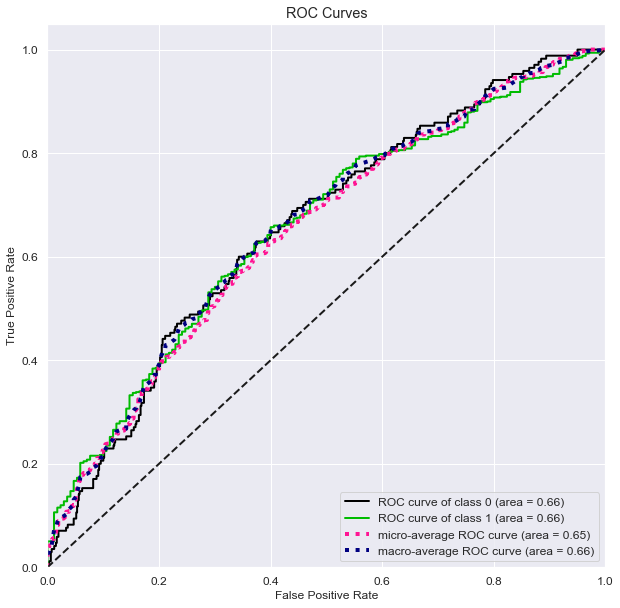

In [1445]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = res['status']
y_probas = lr4.predict_proba(new_X_test_upsampled_scaled)
skplt.metrics.plot_roc(y_true, y_probas, figsize=(10,10))
plt.show();

In [1446]:
#skplt.metrics.plot_precision_recall(y_true, y_probas, figsize=(10,10))
#plt.show();

In [1447]:
res = predict_probability_and_class(lr4, new_X_test_upsampled_scaled, y_test, 0.7)
res.head()

              precision    recall  f1-score   support

           0       0.37      0.12      0.19       170
           1       0.81      0.95      0.87       659

    accuracy                           0.78       829
   macro avg       0.59      0.53      0.53       829
weighted avg       0.72      0.78      0.73       829



,status,0,1,pred_status
0,1,0.262046,0.737954,1
1,1,0.680331,0.319669,1
2,1,0.456001,0.543999,1
3,1,0.882723,0.117277,0
4,1,0.123804,0.876196,1


In [1448]:
len(res.loc[(res['status'] != res['pred_status']) &( res['status'] == 1)])

36

In [1449]:
coef = lr4.coef_[0]

In [1450]:
feature_names = new_X_test_upsampled_scaled.columns
features = pd.DataFrame()
features['name'] = feature_names
features['coef'] = coef

In [1451]:
features

,name,coef
0,monthly_income,0.128854
1,gig_economy_weekly_income,0.089165
2,atm_check_deposits_weekly_income,0.063685
3,direct_deposit_weekly_income,0.116419
4,government_aid_weekly_income,0.036994
5,frequency_heuristic_weekly_income,0.117322
6,large_deposits_weekly_income,-0.148046
7,income_length,0.053863
8,payrolls_per_month,-0.078095
9,income_sources,0.081313


In [1452]:
# predict with lr4 model

In [1453]:
test_application = (0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 20, 1000, 5, 0, 1, 0, 1, 500, 100, 300,
                    3, 100, 0, 300, 2000, 4, 1, 1, 500, 0, 0, 0)

In [1454]:
test_application = np.array(test_application)

In [1455]:
test_df = pd.DataFrame(test_application).T
test_df

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0,0,0,0,0,0,0,0,0,2,...,0,300,2000,4,1,1,500,0,0,0


In [1456]:
scaled = ss3.transform(test_df.iloc[:,0:30 ])

In [1457]:
scaled_df = pd.DataFrame(scaled)

In [1458]:
scaled_df = pd.concat([scaled_df, test_df.iloc[:, 30: ]], axis=1, join='inner')

In [1459]:
scaled_df

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,-1.149047,-0.112096,-0.384437,-0.953979,-0.130953,-0.387258,-0.159754,-1.496716,-0.855597,0.195034,...,-0.05981,3.159966,4.713381,1.322394,0.47356,2.486017,1.302563,0,0,0


In [1460]:
lr4.predict_proba(scaled_df)

array([[0.1617441, 0.8382559]])

In [1461]:
rf3.predict_proba(test_df)

array([[0.13, 0.87]])

In [1462]:
gb3.predict_proba(test_df)

array([[0.19063111, 0.80936889]])

In [1463]:
#Tasks: run on rejected dataset

In [1464]:
30*554

16620

In [1465]:
122*187

22814